## 04 - Evaluate Hopx-MACD and Hopx-derived traced cells
Combine data from IGO16318, IGO17402, and IGO17543 (traced and non-traced cohorts) to evaluate Hopx-derived cells

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from joblib import dump, load

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
#plt.rcParams['figure.figsize'] = (3,4)

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [4]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

## Define scoring Functions

In [5]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [6]:
(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [7]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [8]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

## Load only traced cells

In [9]:
adata = anndata.read_h5ad('write/combined_data.h5ad')

In [10]:
adata.obs[['batch','Group']].value_counts(sort=False)

batch             Group             
traced            6wk_3d                  575
                  8wk                     742
                  12wk_3d                 877
                  14wk                    991
depletion         Saline                10763
untraced_14wk     KPT                    1865
Hopx-MACD         Hopx_GFP+mScarlet+     5661
                  Hopx_GFP+mScarlet-     4847
Hopx-MACD_traced  Hopx_12wk3d            1097
                  Hopx_12wk14d            911
Name: count, dtype: int64

In [11]:
alladata = adata.copy()
#adata2 = alladata[alladata.obs.batch.isin(['traced','untraced_14wk']),:].copy()
adata = adata[adata.obs.batch.isin(['Hopx-MACD','Hopx-MACD_traced']),:].copy()

## Explore Data

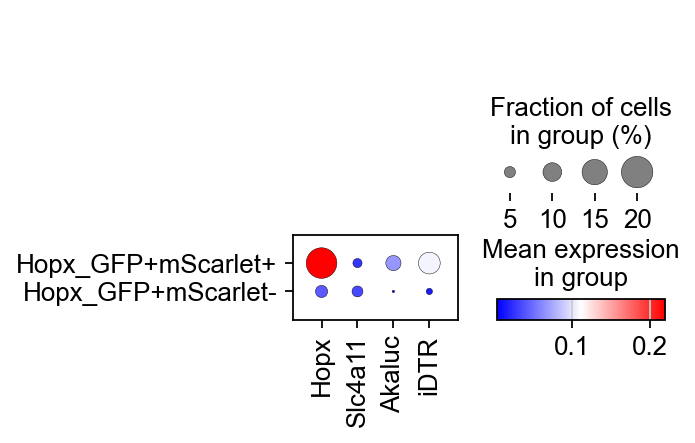

In [12]:
sc.pl.dotplot(adata[~adata.obs.Group.isin(['Hopx_12wk3d','Hopx_12wk14d']),:],['Hopx','Slc4a11','Akaluc','iDTR'],'Group',cmap='bwr')

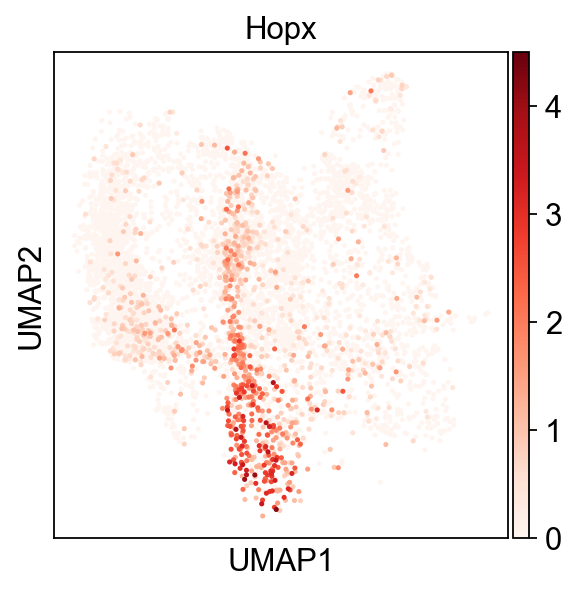

In [13]:
sc.pl.umap(adata[adata.obs.Group.isin(['Hopx_GFP+mScarlet+']),:], color=['Hopx'],cmap='Reds',vmax=4.5)

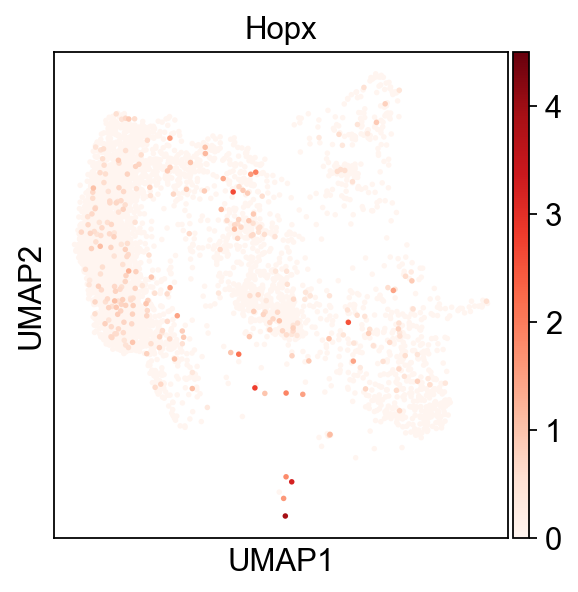

In [14]:
sc.pl.umap(adata[adata.obs.Group.isin(['Hopx_GFP+mScarlet-']),:], color=['Hopx'],cmap='Reds',vmax=4.5)

## Examine Groupings

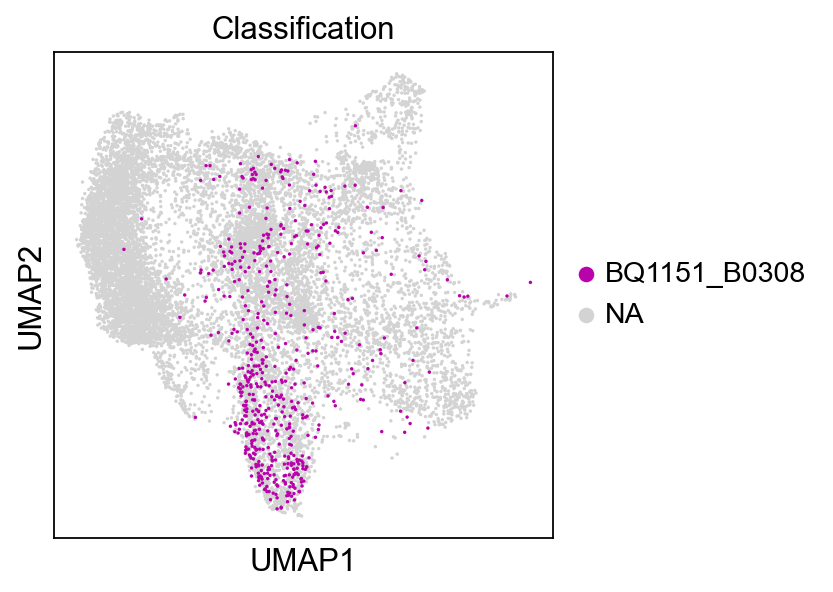

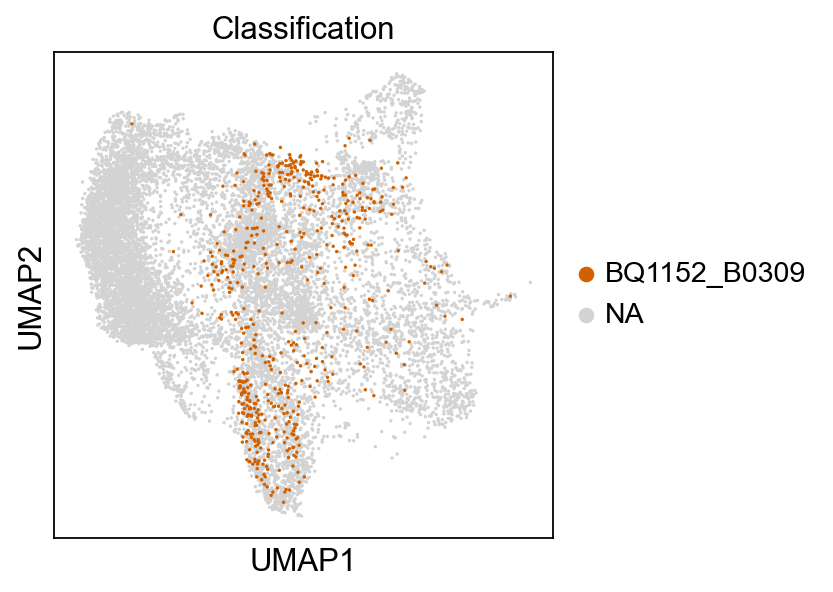

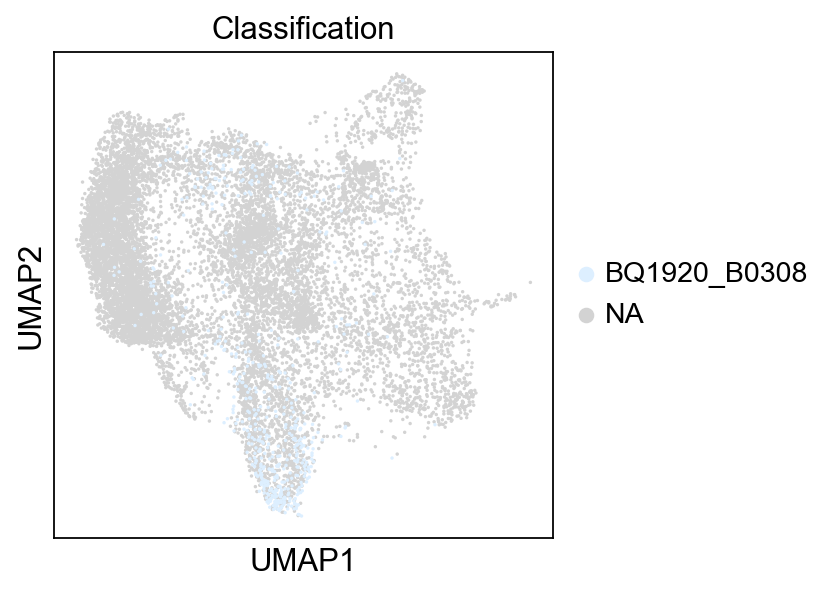

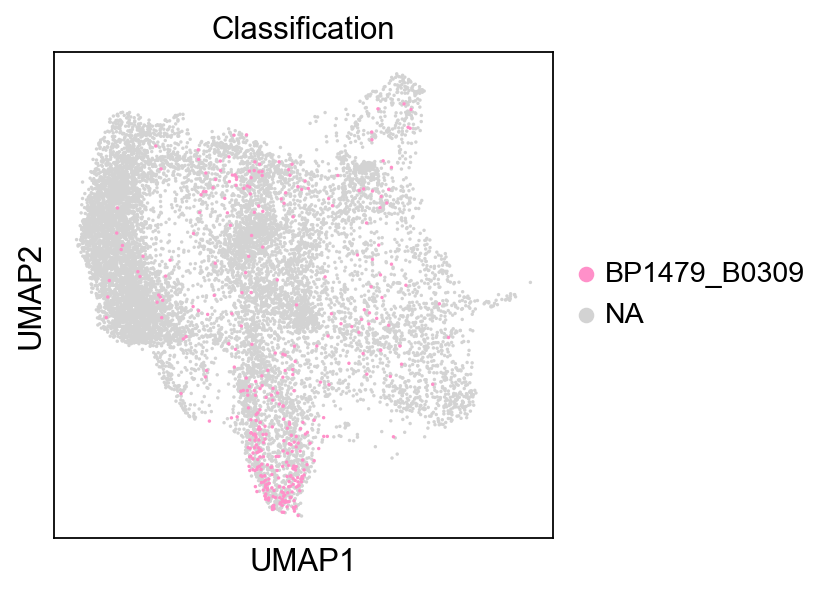

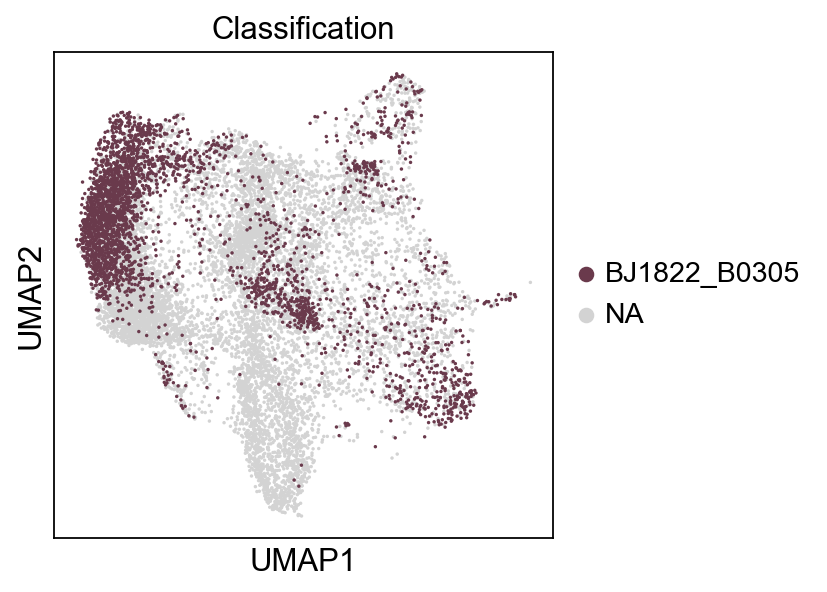

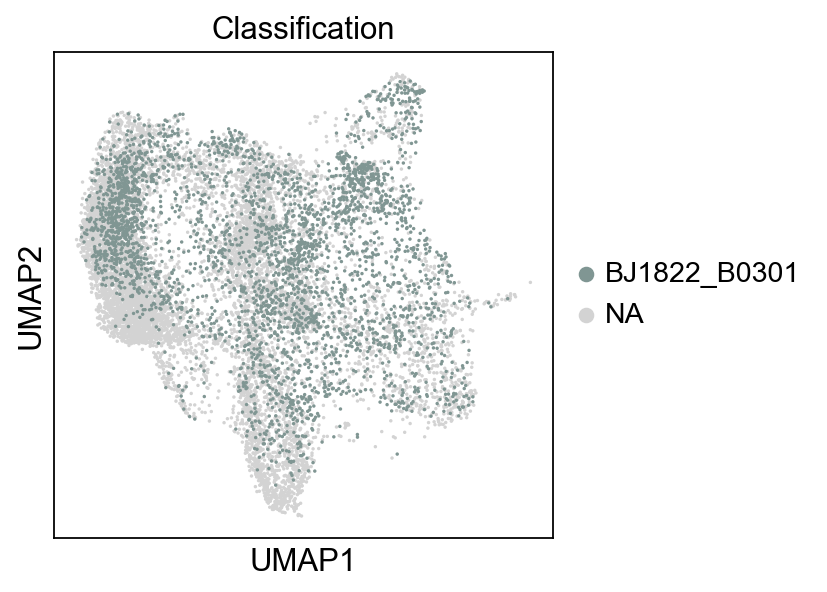

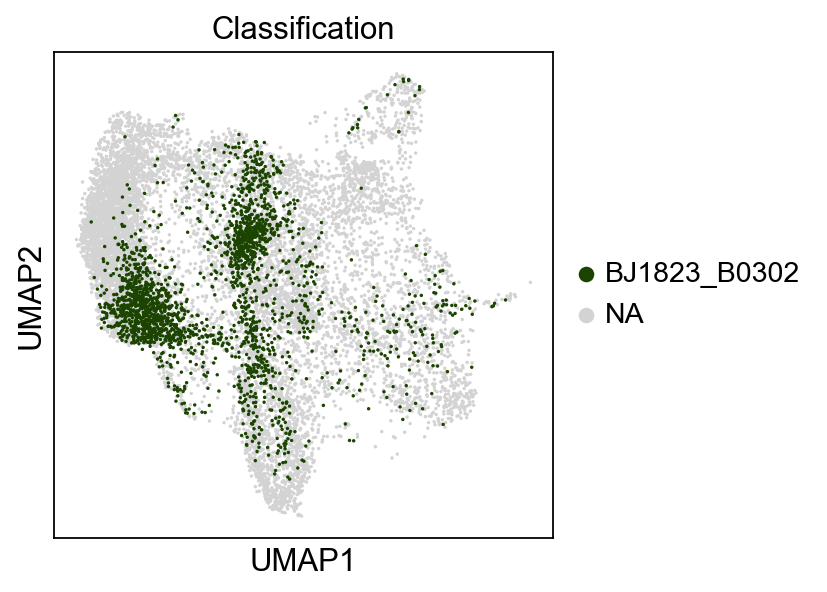

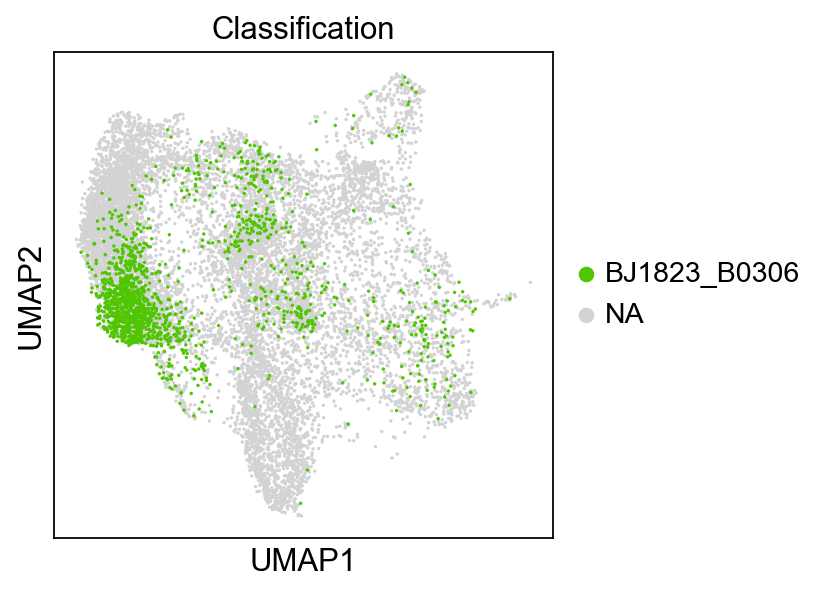

In [15]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

In [16]:
sc.tl.embedding_density(adata,basis='umap', groupby='Group')

computing density on 'umap'
--> added
    'umap_density_Group', densities (adata.obs)
    'umap_density_Group_params', parameter (adata.uns)


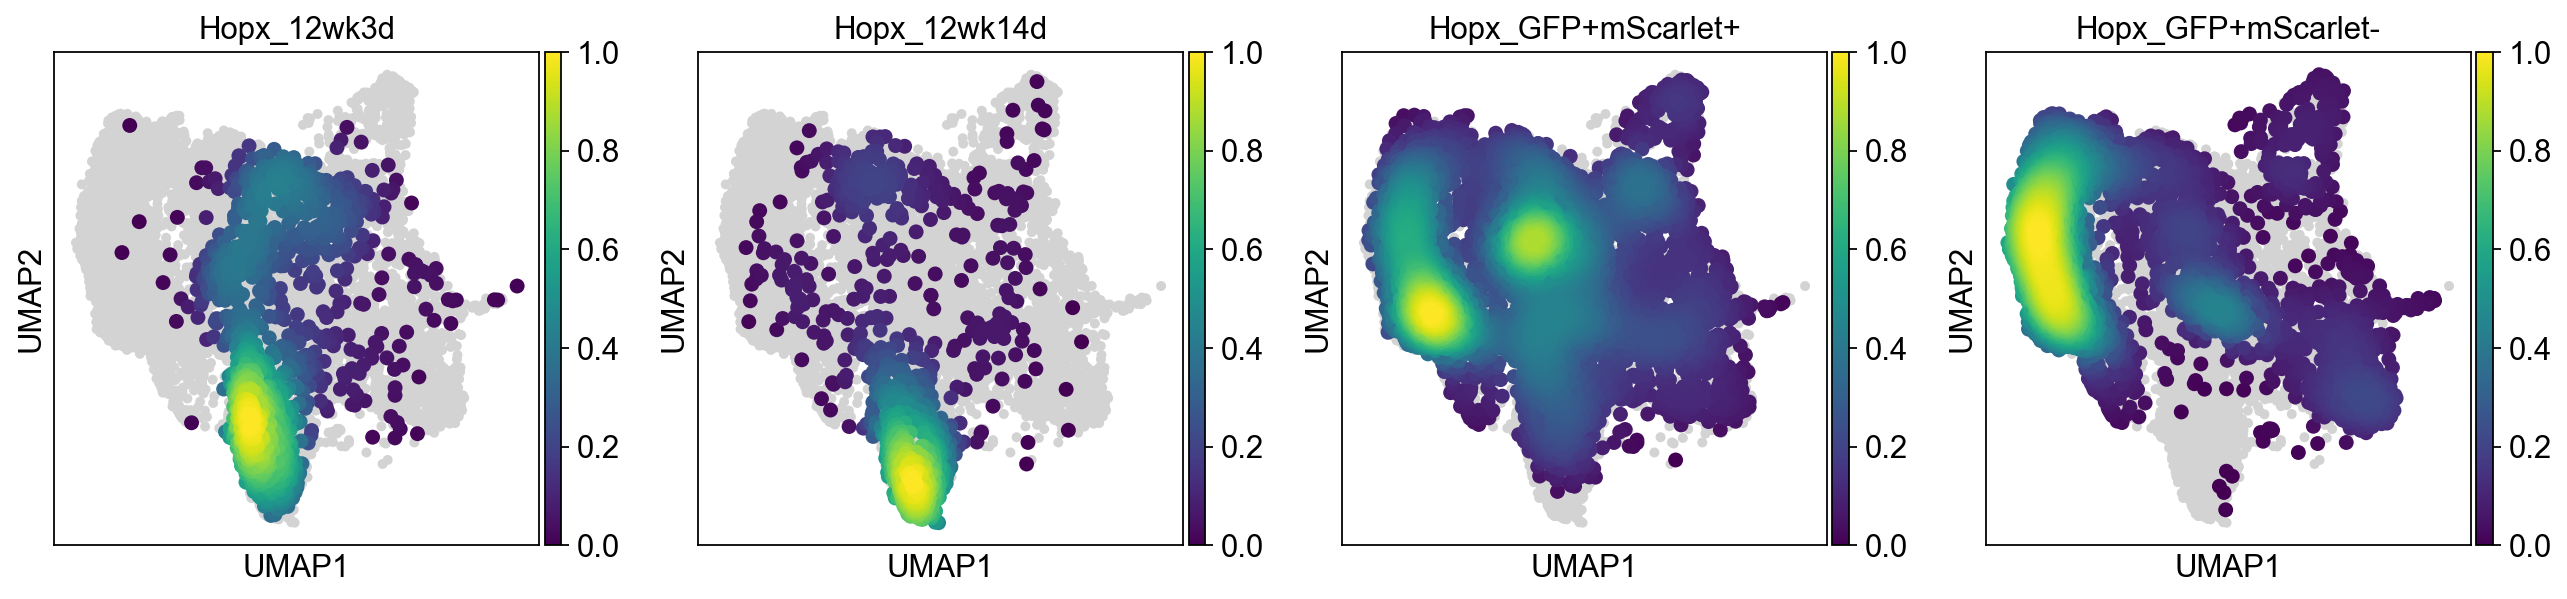

In [17]:
sc.pl.embedding_density(adata,basis='umap',key='umap_density_Group',color_map='viridis')

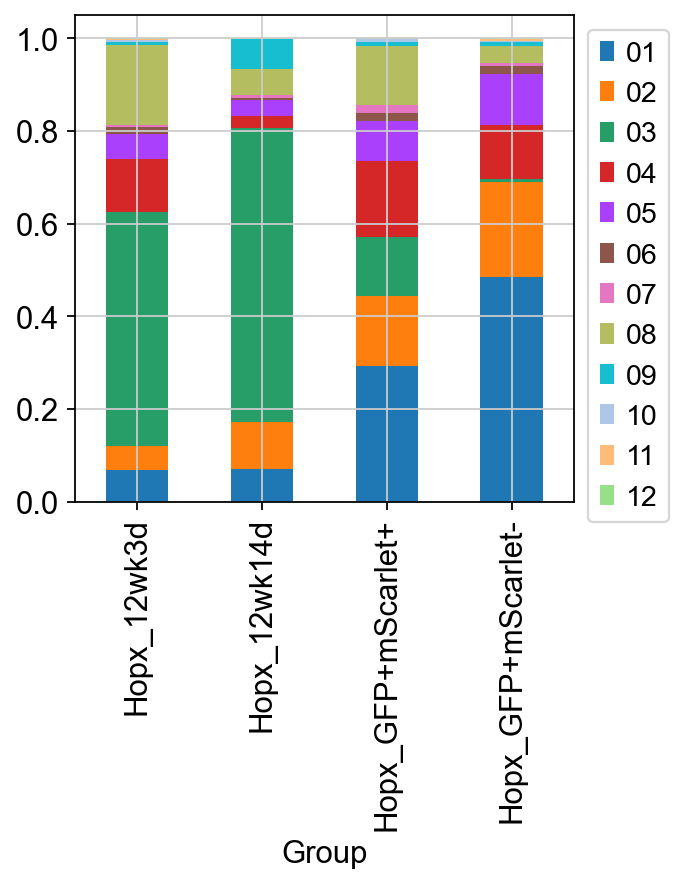

In [18]:
 cell_proportion_df = pd.crosstab(adata.obs['clusterK12'],adata.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

In [19]:
adata.obs[['Group','Classification']].value_counts(sort=False)

Group               Classification
Hopx_12wk3d         BQ1151_B0308       546
                    BQ1152_B0309       551
Hopx_12wk14d        BP1479_B0309       361
                    BQ1920_B0308       550
Hopx_GFP+mScarlet+  BJ1822_B0301      3361
                    BJ1823_B0302      2300
Hopx_GFP+mScarlet-  BJ1822_B0305      3290
                    BJ1823_B0306      1557
Name: count, dtype: int64

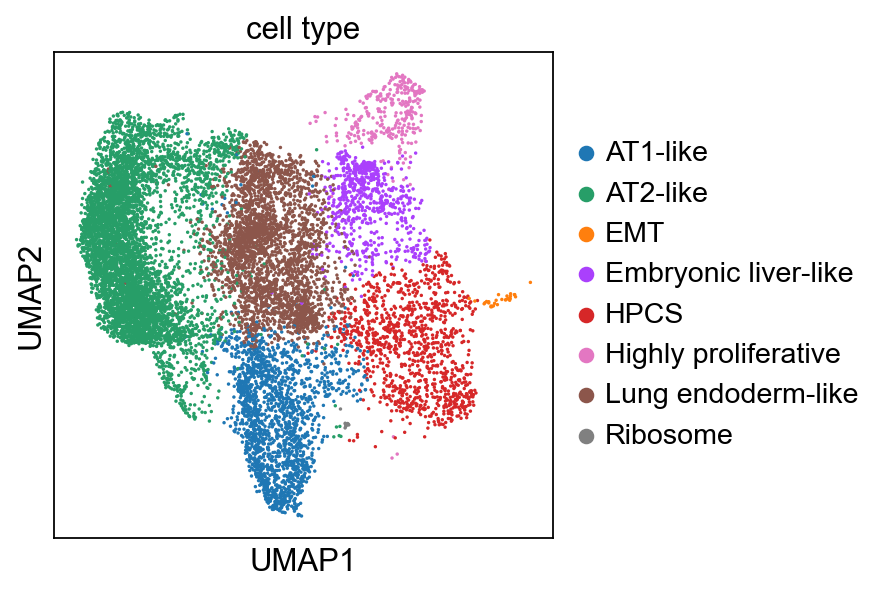

In [20]:
sc.pl.umap(adata, color=['cell type'])

In [21]:
adata.obs[['Group','Classification']].value_counts(sort=False)

Group               Classification
Hopx_12wk3d         BQ1151_B0308       546
                    BQ1152_B0309       551
Hopx_12wk14d        BP1479_B0309       361
                    BQ1920_B0308       550
Hopx_GFP+mScarlet+  BJ1822_B0301      3361
                    BJ1823_B0302      2300
Hopx_GFP+mScarlet-  BJ1822_B0305      3290
                    BJ1823_B0306      1557
Name: count, dtype: int64

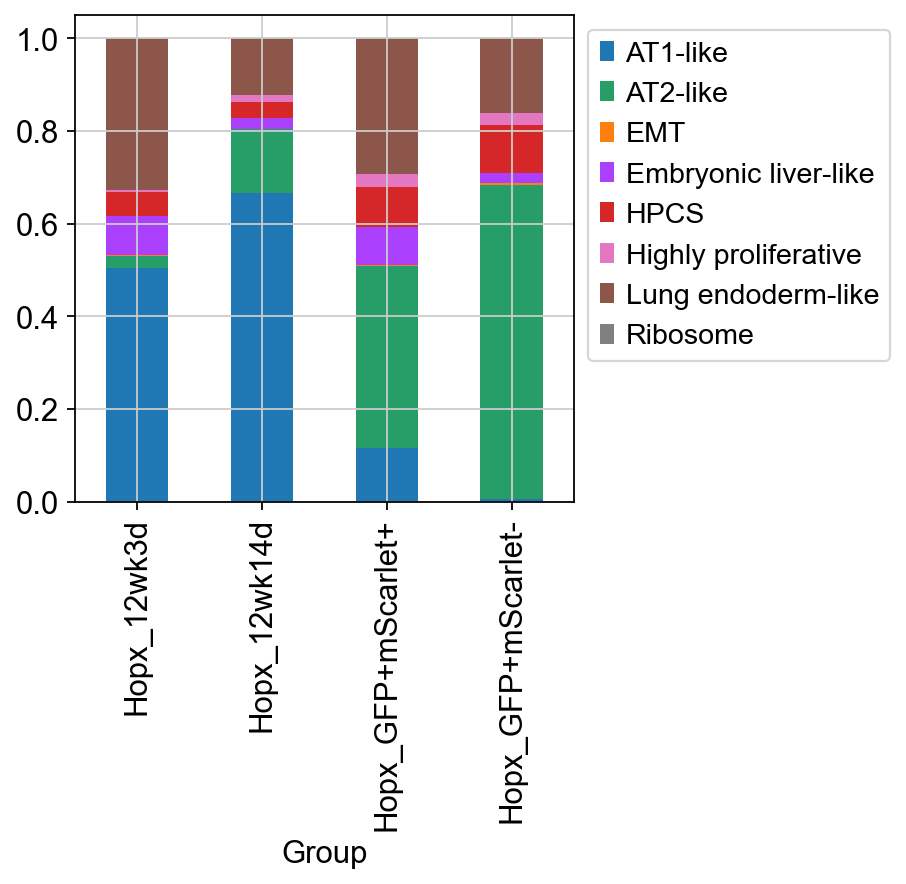

In [22]:
 cell_proportion_df = pd.crosstab(adata.obs['cell type'],adata.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True,color=adata.uns['cell type_colors']).legend(bbox_to_anchor=(1,1))

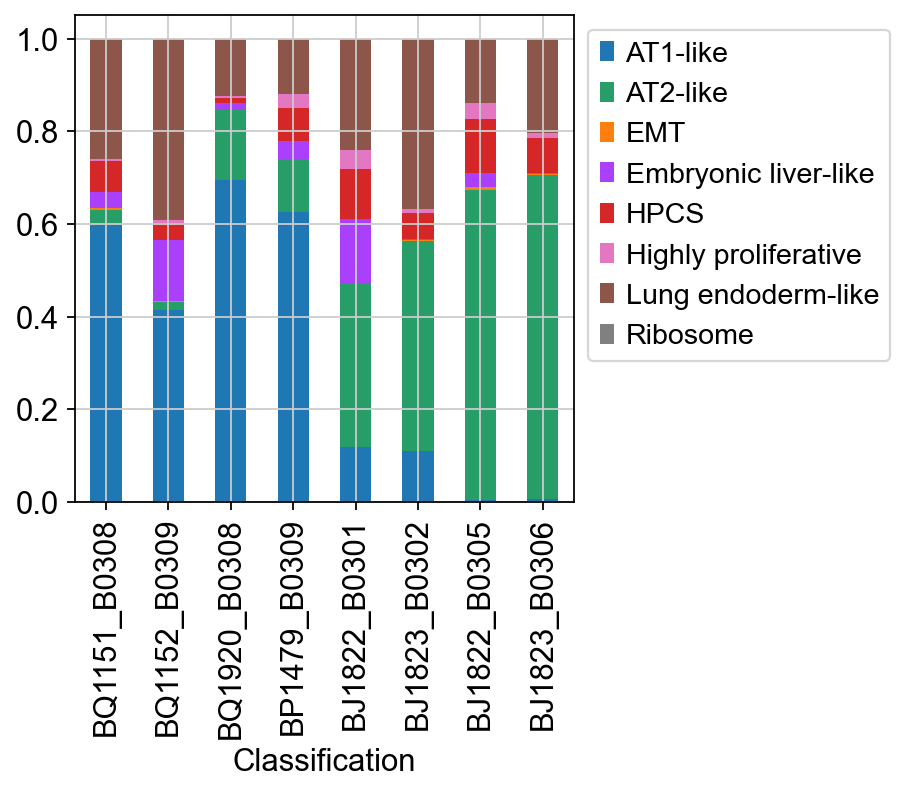

In [23]:
ordered = ['BQ1151_B0308','BQ1152_B0309', # Hopx 12wk 3d
           'BQ1920_B0308','BP1479_B0309', # Hopx 12wk 14d
           'BJ1822_B0301','BJ1823_B0302', # Hopx GFP+mScarlet+
           'BJ1822_B0305','BJ1823_B0306',] # Hopx GFP+mScarlet-
cell_proportion_df = pd.crosstab(adata.obs['cell type'],adata.obs['Classification'], normalize='columns')[ordered].T.plot(kind='bar', stacked=True, color=adata.uns['cell type_colors']).legend(bbox_to_anchor=(1,1))

In [24]:
sc.tl.embedding_density(adata,basis='umap', groupby='Classification')

computing density on 'umap'
--> added
    'umap_density_Classification', densities (adata.obs)
    'umap_density_Classification_params', parameter (adata.uns)


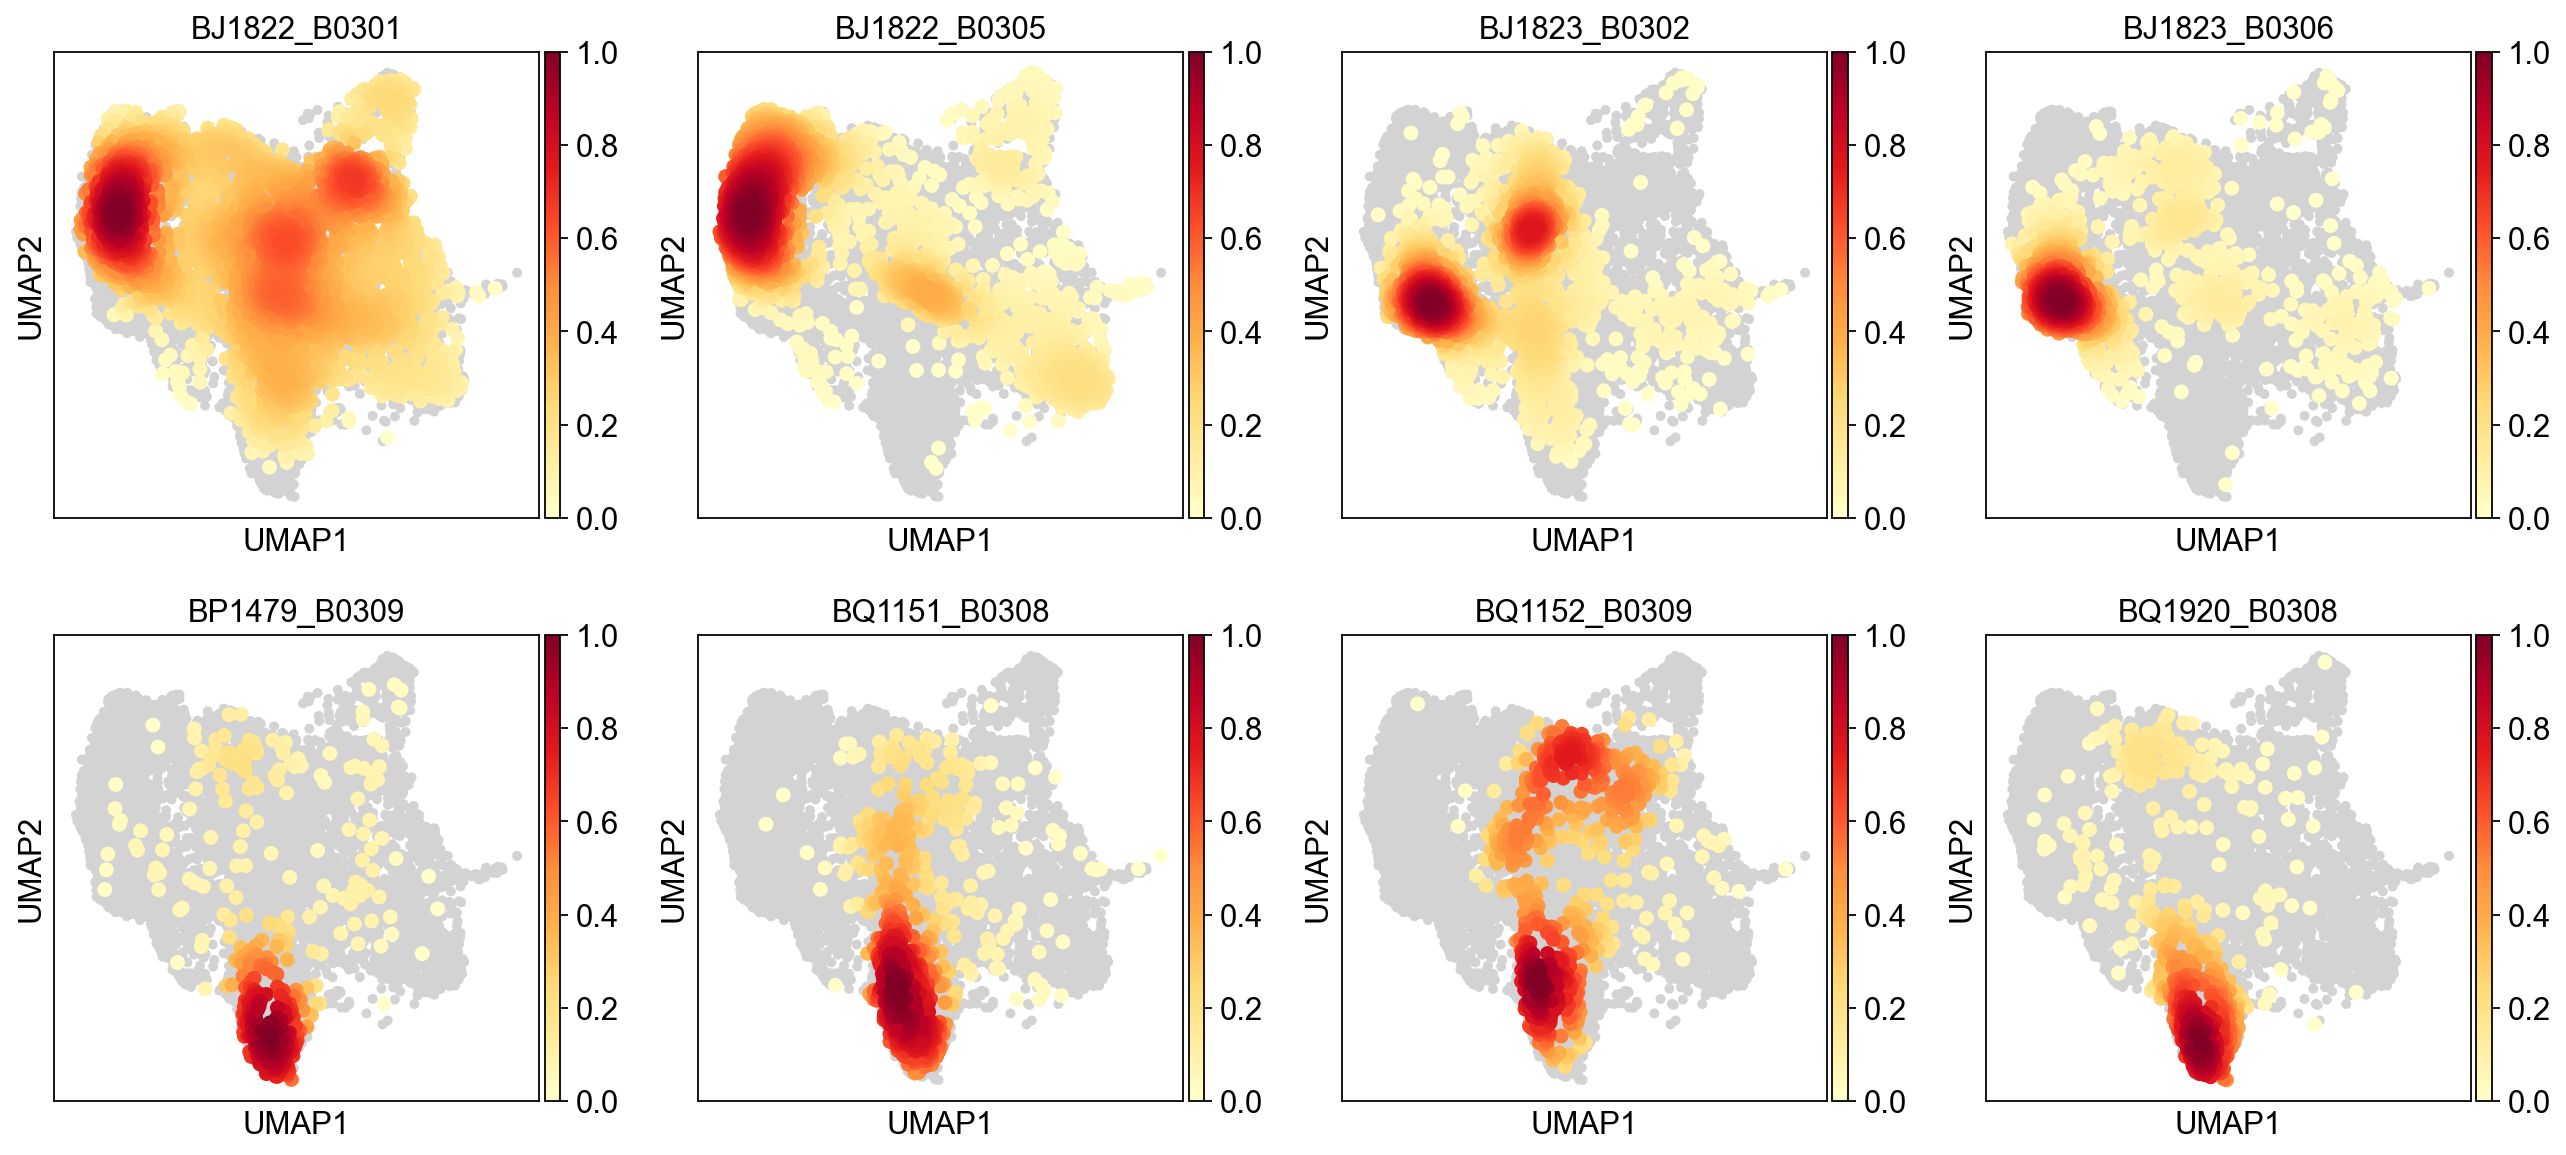

In [25]:
sc.pl.embedding_density(adata,basis='umap',key='umap_density_Classification')

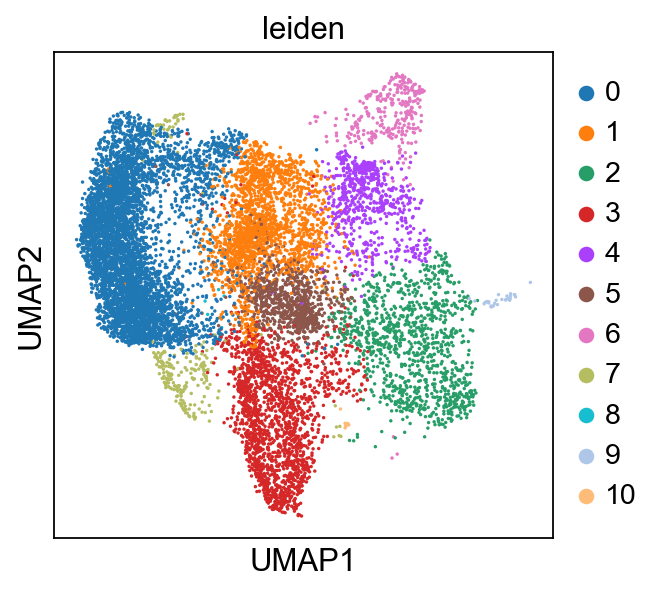

In [26]:
sc.pl.umap(adata, color=['leiden'])

## Evaluate rough clusters

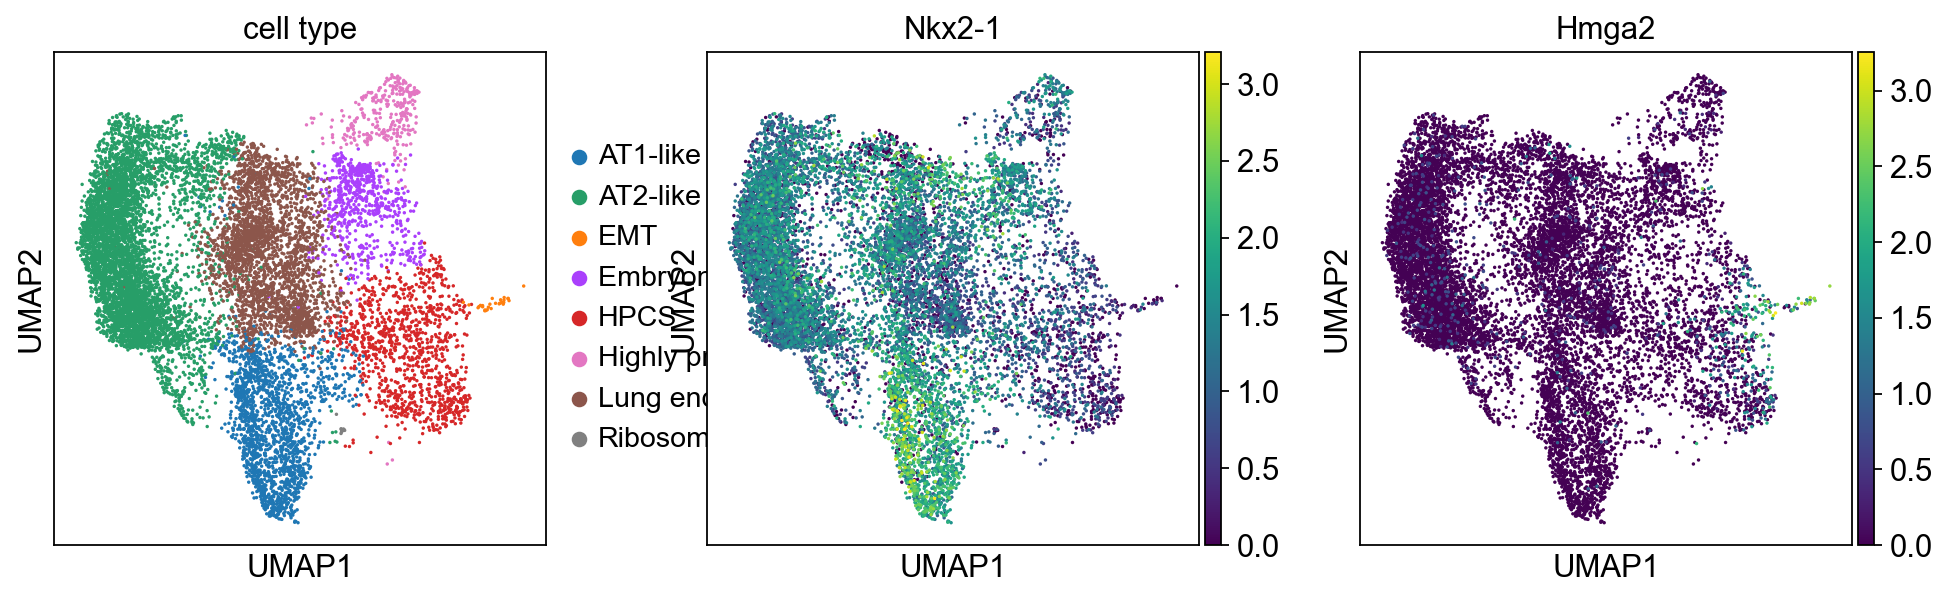

In [27]:
sc.pl.umap(adata, color=['cell type','Nkx2-1','Hmga2'])

## Figures for the paper

### Generate barplots

In [28]:
adata.obs.Group.value_counts()

Group
Hopx_GFP+mScarlet+    5661
Hopx_GFP+mScarlet-    4847
Hopx_12wk3d           1097
Hopx_12wk14d           911
Name: count, dtype: int64

In [29]:
adata2 = adata[adata.obs.Group.isin(['Hopx_12wk3d','Hopx_12wk14d']),:]

In [30]:
adata2.obs.Group.value_counts()

Group
Hopx_12wk3d     1097
Hopx_12wk14d     911
Name: count, dtype: int64

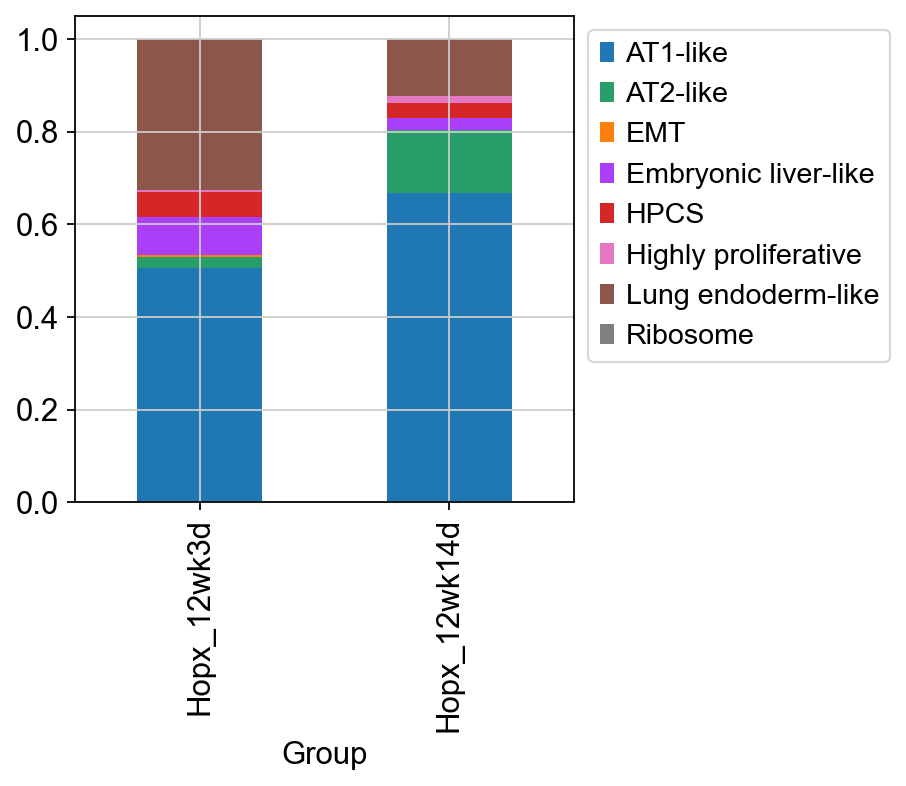

In [31]:
cell_proportion_df = pd.crosstab(adata2.obs['cell type'],adata2.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True,color=adata2.uns['cell type_colors']).legend(bbox_to_anchor=(1,1))
cell_proportion_df.get_figure().savefig('figures/Fig2g_Hopx_cell state proportions.svg')

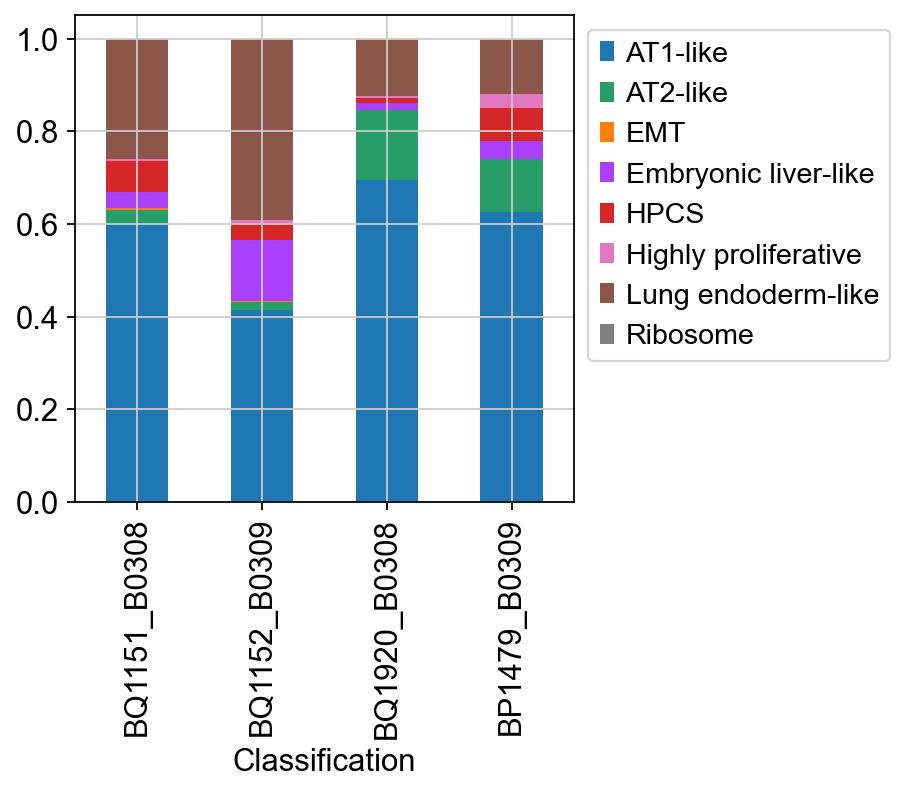

In [32]:
ordered = ['BQ1151_B0308','BQ1152_B0309', # Hopx 12wk 3d
           'BQ1920_B0308','BP1479_B0309',] # Hopx 12wk 14d
#           'BJ1822_B0301','BJ1823_B0302', # Hopx GFP+mScarlet+
#           'BJ1822_B0305','BJ1823_B0306',] # Hopx GFP+mScarlet-
cell_proportion_df = pd.crosstab(adata.obs['cell type'],adata.obs['Classification'], normalize='columns')[ordered].T.plot(kind='bar', stacked=True, color=adata.uns['cell type_colors']).legend(bbox_to_anchor=(1,1))
cell_proportion_df.get_figure().savefig('figures/Ext_Data_Fig8b_Hopx_mice_cell state proportions.svg')

### Generate uMAPs

In [33]:
alladata.obs.batch.value_counts()

batch
depletion           10763
Hopx-MACD           10508
traced               3185
Hopx-MACD_traced     2008
untraced_14wk        1865
Name: count, dtype: int64

In [34]:
adata = alladata[alladata.obs.batch.isin(['traced','Hopx-MACD_traced']),:]

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_51093/388986162.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[type_col] = adata.obs[type_col].astype('category')


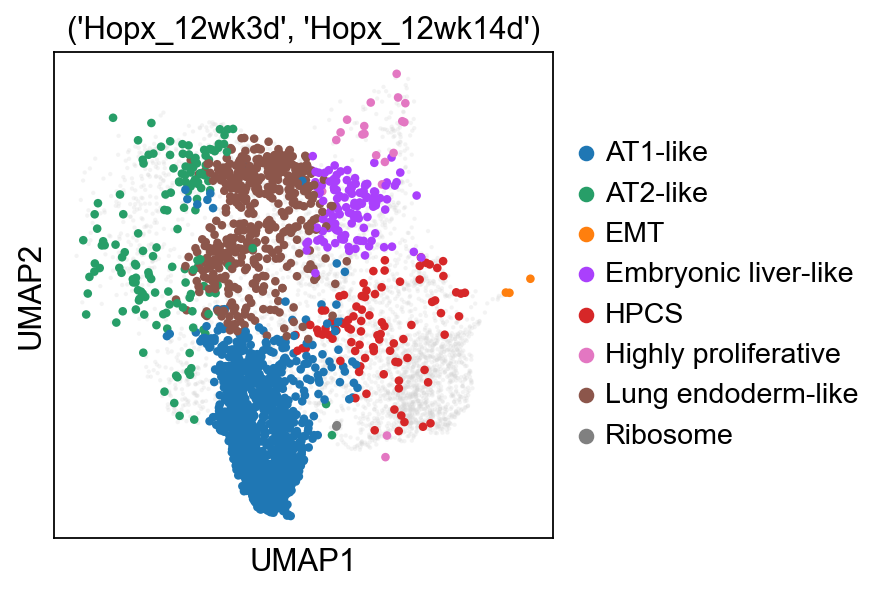

In [46]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

group_col = 'Group'
type_col  = 'cell type'
groups    = [('Hopx_12wk3d','Hopx_12wk14d')]  # order you want

# Ensure cell type is categorical with a stable, global order
adata.obs[type_col] = adata.obs[type_col].astype('category')
type_cats = list(adata.obs[type_col].cat.categories)

# Use the exact palette already stored in .uns
# (Scanpy maps colors to categories by order.)
palette = adata.uns[f'{type_col}_colors']

# sanity check: palette length should match number of categories
if len(palette) != len(type_cats):
    raise ValueError(f"Palette length ({len(palette)}) != categories ({len(type_cats)})")
palette = list(adata.uns[f'{type_col}_colors'])
# styling
bg_size, bg_alpha = 15, 0.25        # background points
fg_size = 60                       # foreground points

for grp in groups:
    # First: draw a standard UMAP *background* to get Scanpy's default figure/axes sizing
    fig = sc.pl.umap(
        adata,
        color=None,                # no color, just points
        size=bg_size,
        alpha=bg_alpha,
        frameon=True,              # keep axes/frame like default
        show=False,
        return_fig=True            # <- get the same-sized Axes Scanpy uses
    )
    ax = fig.axes[0]

    # Foreground: this group's cells, colored by cell type, using the same palette as adata.uns
    adata_grp = adata[adata.obs[group_col].isin(grp), :].copy()
    # Make sure the subset keeps the same category order so colors line up
    #adata_grp.obs[type_col] = adata_grp.obs[type_col].cat.set_categories(type_cats)

    sc.pl.umap(
        adata_grp,
        color=type_col,
        palette=palette,           # exact same color scheme
        use_raw=False,             # avoid .raw overriding values
        size=fg_size,
        na_color='darkgray',
        frameon=True,
        ax=ax,                     # overlay on the SAME axes
        show=False,
    )

    ax.set_title(grp)              # title per panel, like standard
    plt.savefig(f'figures/Fig2e_uMAP_{grp}_cellstates.svg')
    plt.show()


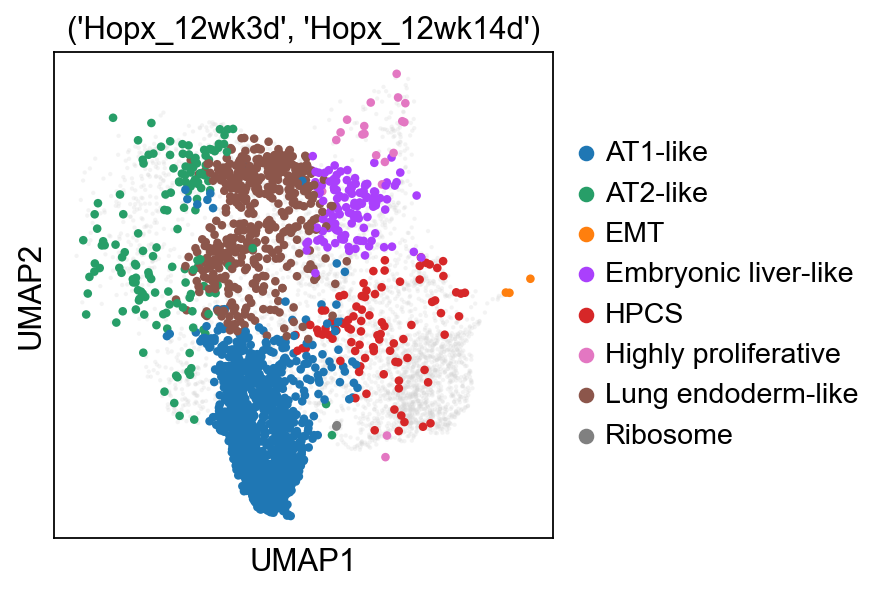

In [36]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

group_col = 'Group'
type_col  = 'cell type'
groups    = [('Hopx_12wk3d','Hopx_12wk14d')]  # order you want

# Ensure cell type is categorical with a stable, global order
adata.obs[type_col] = adata.obs[type_col].astype('category')
type_cats = list(adata.obs[type_col].cat.categories)

# Use the exact palette already stored in .uns
# (Scanpy maps colors to categories by order.)
palette = adata.uns[f'{type_col}_colors']

# sanity check: palette length should match number of categories
if len(palette) != len(type_cats):
    raise ValueError(f"Palette length ({len(palette)}) != categories ({len(type_cats)})")
palette = list(adata.uns[f'{type_col}_colors'])
# styling
bg_size, bg_alpha = 15, 0.25        # background points
fg_size = 60                       # foreground points

for grp in groups:
    # First: draw a standard UMAP *background* to get Scanpy's default figure/axes sizing
    fig = sc.pl.umap(
        adata,
        color=None,                # no color, just points
        size=bg_size,
        alpha=bg_alpha,
        frameon=True,              # keep axes/frame like default
        show=False,
        return_fig=True            # <- get the same-sized Axes Scanpy uses
    )
    ax = fig.axes[0]

    # Foreground: this group's cells, colored by cell type, using the same palette as adata.uns
    adata_grp = adata[adata.obs[group_col].isin(grp), :].copy()
    # Make sure the subset keeps the same category order so colors line up
    adata_grp.obs[type_col] = adata_grp.obs[type_col].cat.set_categories(type_cats)

    sc.pl.umap(
        adata_grp,
        color=type_col,
        #palette=palette,           # exact same color scheme
        use_raw=False,             # avoid .raw overriding values
        size=fg_size,
        na_color='darkgray',
        frameon=True,
        ax=ax,                     # overlay on the SAME axes
        show=False,
    )

    ax.set_title(grp)              # title per panel, like standard
    plt.savefig(f'figures/Fig2e_uMAP_{grp}_cellstates.svg')
    plt.show()


## Generating stats

In [31]:
# Response to Reviewer 1 Point 2: How frequent is the HPCS
# Combine 12w3d since they are similar enough

counts = adata[adata.obs.Classification.isin(['BQ1151_B0308','BQ1152_B0309']),:].obs.groupby('Classification')['cell type'].value_counts(normalize=True).reset_index()
print(f'HPCS mean: {counts[counts["cell type"] == "HPCS"]["proportion"].mean()} +/- {counts[counts["cell type"] == "HPCS"]["proportion"].std()}')
print(f'not HPCS mean: {(1-counts[counts["cell type"] == "HPCS"]["proportion"]).mean()} +/- {(1-counts[counts["cell type"] == "HPCS"]["proportion"]).std()}')
print(f'AT1-like mean: {counts[counts["cell type"] == "AT1-like"]["proportion"].mean()} +/- {counts[counts["cell type"] == "AT1-like"]["proportion"].std()}')
print(f'not AT1-like mean: {(1-counts[counts["cell type"] == "AT1-like"]["proportion"]).mean()} +/- {(1-counts[counts["cell type"] == "AT1-like"]["proportion"]).std()}')

HPCS mean: 0.05293904522579658 +/- 0.020967869258574787
not HPCS mean: 0.9470609547742035 +/- 0.02096786925857479
AT1-like mean: 0.5054313502589365 +/- 0.12959605147172926
not AT1-like mean: 0.49456864974106357 +/- 0.12959605147172928


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_33852/1877611120.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata[adata.obs.Classification.isin(['BQ1151_B0308','BQ1152_B0309']),:].obs.groupby('Classification')['cell type'].value_counts(normalize=True).reset_index()


In [30]:
# Response to Reviewer 1 Point 2: How frequent is the HPCS
# Combine 12w3d since they are similar enough

counts = adata[adata.obs.Classification.isin(['BQ1920_B0308','BP1479_B0309']),:].obs.groupby('Classification')['cell type'].value_counts(normalize=True).reset_index()
print(f'HPCS mean: {counts[counts["cell type"] == "HPCS"]["proportion"].mean()} +/- {counts[counts["cell type"] == "HPCS"]["proportion"].std()}')
print(f'not HPCS mean: {(1-counts[counts["cell type"] == "HPCS"]["proportion"]).mean()} +/- {(1-counts[counts["cell type"] == "HPCS"]["proportion"]).std()}')
print(f'AT1-like mean: {counts[counts["cell type"] == "AT1-like"]["proportion"].mean()} +/- {counts[counts["cell type"] == "AT1-like"]["proportion"].std()}')
print(f'not AT1-like mean: {(1-counts[counts["cell type"] == "AT1-like"]["proportion"]).mean()} +/- {(1-counts[counts["cell type"] == "AT1-like"]["proportion"]).std()}')

HPCS mean: 0.04055653487786452 +/- 0.04449911473646896
not HPCS mean: 0.9594434651221355 +/- 0.04449911473646898
AT1-like mean: 0.6602921178544447 +/- 0.048441533304958054
not AT1-like mean: 0.33970788214555525 +/- 0.048441533304958054


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_33852/2847951604.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata[adata.obs.Classification.isin(['BQ1920_B0308','BP1479_B0309']),:].obs.groupby('Classification')['cell type'].value_counts(normalize=True).reset_index()
